<img src="mioti.png" style="height: 100px">
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Deep Learning</center>

# Worksheet S5: Redes Neuronales Convolucionales en Keras (CNNs), CIFAR

## Objetivos

El objetivo de este worksheet es presentar la base de datos CIFAR, con la que profundizaremos en el uso de las redes convolucionales (CNNs) utilizando redes preentrenadas. También veremos la técnica de Dropout utilizada para reducir el sobreajuste (overfitting).

## Introducción

Continuando con la sesión anterior en la que trabajamos con redes neuronales convolucionales (CNNs) en Keras, en esta sesión vamos a explorar su uso para una de las bases de datos de imágenes para clasificación de objetos, esta vez en color en lugar de en escala de grises. Las CNNs están preparadas para tratar con este tipo de imágenes, que en lugar de un canal, cuentan con tres canales (RGB).

## CIFAR Dataset

El reconocimiento de objetos en imágenes es uno de los problemas más comunes en Machine Learning a día de hoy.

El dataset CIFAR-10 consiste en 60.000 imágenes a color de tamaño 32x32 con 10 clases (avión, coche, pájaro, gato, ciervo, perro, rana, caballo, barco, camión). Hay un total de 50.000 imágenes para el entrenamiento y 10.000 imágenes de test.

Existe un dataset CIFAR-100 con 100 clases en lugar de 10, pero utilizaremos CIFAR-10 debido a que lanzar experimentos en el portatil con CIFAR-100 puede ser demasiado lento.

Keras incluye funciones para cargar este dataset de forma cómoda:


In [1]:
# %tensorflow_version 2.x  # sólo es necesaria en colab
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow import keras


# Loading the CIFAR-10 datasets
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

### Comprobación y análisis del dataset

A continuación, vamos a comprobar que todas las imágenes se han cargado de forma correcta. 

Además, para analizar un poco más en profundidad las características de este conjunto de datos, vamos a comprobar el balanceo de las clases tanto en entrenamiento como en test.


In [2]:
import numpy as np

## Tamaño del dataset
print("El conjunto de entrenamiento está compuesto por: " + str(x_train.shape))
print("El conjunto de test está compuesto por: " + str(x_test.shape))

## Comprobación de los datos
print("Frecuencia de las clases en el conjunto de entrenamiento:")
print(np.sum(y_train==(np.unique(y_train)),axis=0))
print("Frecuencia de las clases en el conjunto de test:")
print(np.sum(y_test==(np.unique(y_test)),axis=0))
print("Como podemos ver, las clases sí están perfectamente balanceadas")


El conjunto de entrenamiento está compuesto por: (50000, 32, 32, 3)
El conjunto de test está compuesto por: (10000, 32, 32, 3)
Frecuencia de las clases en el conjunto de entrenamiento:
[5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
Frecuencia de las clases en el conjunto de test:
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
Como podemos ver, las clases sí están perfectamente balanceadas



También comprobamos el rango de valores que toman los datos de entrada, y mostramos las primeras 10 imágenes de entrenamiento.


El rango de valores para el conjunto de entrenamiento es: (0, 255)
El rango de valores para el conjunto de test es: (0, 255)


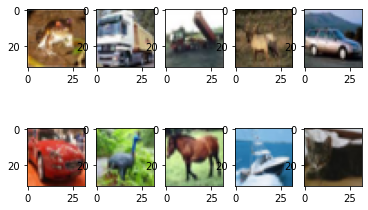

 La mejor forma de ver si las imágenes son correctas es cargarlas y pintar unas cuantas, 
 como podemos ver todo está bien


In [3]:
############## Si al ejecutar el Kernel se bloquea, 
############## utiliza estas líneas para permitir la 
############## duplicación de librerías
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
##############

import matplotlib.pyplot as plt

## Rango de valores
print("El rango de valores para el conjunto de entrenamiento es: ("+ str(x_train.min()) + ", " + str(x_train.max()) +")")
print("El rango de valores para el conjunto de test es: ("+ str(x_test.min()) + ", " + str(x_test.max()) +")")

i=0
while i<10:
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i])
    i=i+1
plt.show()

print(" La mejor forma de ver si las imágenes son correctas es cargarlas y pintar unas cuantas, \n como podemos ver todo está bien")

### Normalización de los datos de entrada y preparación de las etiquetas

Como siempre, es muy importante trabajar con datos normalizados para entrenar nuestros modelos. 

- En el apartado anterior hemos obtenido el valor máximo y mínimo que pueden tomar los datos de entrada, a partir de este máximo y este mínimo tenemos que normalizar las matrices x_train y x_test de forma que los datos queden contenidos en el rango [0,1]

- Como vimos en otras sesiones, cuando resolvemos un problema de clasificación multiclase con una capa softmax necesitamos que las etiquetas sean arrays con tantos valores como clases tenemos. Las matrices y_train y y_test están en un formato unidimensional con valores escalares. Utilizar la herramienta np_utils.to_categorical() para transformar dichas matrices.

In [4]:
from tensorflow.keras import utils

y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test,10)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

## Utilizando redes preentrenadas

Como vimos en la última sesión, tardamos varios minutos en entrenar nuestra red neuronal para conseguir un resultado de aproximadamente un 70%. No esta mal, pero desde luego podemos mejorarlo mucho.

La principal limitación del resultado que obtuvimos no está en el modelo (a pesar de ser muy mejorable) si no en la cantidad de datos y su entrenamiento. Hemos comentado en varias ocasiones que el problema de reconocimiento de objetos en imágenes es uno de los que más atención recibe, ¿podemos aprovecharnos de esto?.

En esta sección vamos a utilizar una red neuronal preentrenada como extractor de características en nuestra propia red neuronal para mejorar nuestro modelo. Las redes CNN lo que hacen es mapear la presencia de distintas características en nuestra entrada, por tanto, podmeos utilizar una red CNN preentrenada con millones de imágenes como comienzo de nuestro modelo.

### Fine tunning

Cuando utilizamos la técnica que acabamos de describir, necesitaremos ajustar las capas finales de nuestro modelo para trabajar con nuestro problema de forma específica, es decir, para ajustarse a nuestros datos y al problema que estamos intentando resolver. 

De esta forma, podemos aprovecharnos de redes entrenadas con millones de datos ya que son muy buenas encontrando caracterísicas como lineas o bordes que son similares en cualquier tipo de imagen. Por tanto, no necesitamos reentrenar las capas iniciales de nuestra red, sólo ajustar las capas finales.


### Modelo preentrenado

Vamos a utilizar el modelo VGG16, un modelo muy potente entrenado para resolver imagenet. Imagenet es un dataset de google que contiene 14 millones de imagenes de 1000 clases diferentes.

<img src="VGG16.pbm" style="height: 400px">

Nuestra intención es utilizar este modelo, pero sólo queremos utilizar la base convolucional. De esta forma, cuando carguemos el modelo, vamos a especificar que no queremos cargar la capa superior (encargada de la clasificación). Vamos a especificar el tamaño de la entrada y vamos a decirle que queremos utilizar los pesos predeterminados obtenidos con el dataset imagenet.


In [5]:
IMG_SHAPE = (32, 32, 3)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [6]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [7]:
feature_batch = base_model(x_train[0].reshape(1,32,32,3))
print(feature_batch.shape)

(1, 1, 1, 512)


En este momento, nuestro base_model tiene por salida un tensor de tamaño (1, 1, 512). Este tensor es una extracción de características de nuestra imagen original (1, 32, 32, 3). 

### Freeze

Lo siguiente que vamos a hacer es especificar que no vamos a entrenar el modelo base, de esta forma cuando entrenmos el modelo total sólo cambiarán los pesos del resto de capas

In [8]:
base_model.trainable = False

### Capas personalizadas

Por último, tenemos que añadir a nuestro modelo las capas que si vamos a entrenar:
- Flatten, para asegurarnos de que la entrada a nuestra capa Dense es de rango 1
- Capa dense para realizar la clasificación
- Capa de salida, que será también de tipo dense con función de activación softmax.

In [9]:
flatten = tf.keras.layers.Flatten()
classif = tf.keras.layers.Dense(256)
output = tf.keras.layers.Dense(10, activation='softmax')

model = tf.keras.Sequential([
  base_model,
  flatten,
  classif,
  output
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 14,848,586
Trainable params: 133,898
Non-trainable params: 14,714,688
_________________________________________________________________


### Entrenamiento y Test

Una vez tenemos el modelo, el resto ya sabemos cómo funciona, vamos a probar!

In [11]:
## Reducción de datos para poder correr en local, correr en colab para quitar esto y obtener resultados reales
x_train = x_train[1:500,:,:]
x_test = x_test[1:100,:,:]
y_train = y_train[1:500,:]
y_test = y_test[1:100,:]


model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=64, epochs=5,verbose=1,validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print(score)

Epoch 1/5
8/8 [==============================] - 2s 218ms/step - loss: 2.3518 - accuracy: 0.1723 - val_loss: 2.0429 - val_accuracy: 0.2424
Epoch 2/5
8/8 [==============================] - 1s 172ms/step - loss: 1.8277 - accuracy: 0.4028 - val_loss: 1.7620 - val_accuracy: 0.3838
Epoch 3/5
8/8 [==============================] - 1s 190ms/step - loss: 1.5959 - accuracy: 0.4790 - val_loss: 1.6880 - val_accuracy: 0.3939
Epoch 4/5
8/8 [==============================] - 1s 177ms/step - loss: 1.4473 - accuracy: 0.4930 - val_loss: 1.5711 - val_accuracy: 0.4444
Epoch 5/5
8/8 [==============================] - 1s 173ms/step - loss: 1.3162 - accuracy: 0.5912 - val_loss: 1.5623 - val_accuracy: 0.4545
[1.5622509717941284, 0.4545454680919647]


## Dropout

Una vez presentada la base de datos con la que vamos a trabajar en esta sesión, vamos a presentar la técnica del dropout.

El dropout es una de las técnicas que se utilizan a menudo en redes neuronales para mejorar el rendimiento final, disminuir el sobreentrenamiento y facilitar que cada neurona aprenda cosas de forma independiente. Esta técnica selecciona de forma aleatoria algunas de las neuronas de una capa oculta para cada iteración en tiempo de entrenamiento y las desactiva. Para obtener un mejor entendimiento de esta técnica, ver este vídeo: https://www.youtube.com/watch?v=zQr2hGcp41g.

En Keras existe la capa Dropout, que permite aplicar esta técnica con una probabilidad dada. 

Es importante que apliquemos esta técnica tan sólo cuando realicemos el train, pero no cuando realizamos el test. Para ello, deberemos pasar la salida de la capa feed-forward o dense por la capa dropout, lo que desactivará en tiempo de train algunas de sus neuronas. Cuando ejecutamos la evaluación del modelo, Keras trata automáticamente con el hecho de que no tiene que desactivar neuronas, y pondera los resultados de las activaciones.

Así podemos importar la capa dropout de Keras


In [12]:
from tensorflow.keras.layers import Dropout